## Combined ADCP and CTD particle test with CMEMS data

In [3]:
import numpy as np
import pyproj
from datetime import timedelta
from shapely.geometry import Point, Polygon
from parcels import Field, FieldSet, JITParticle, Variable, ParticleSet

### Read sample input data

In [4]:
# Load the CMEMS data (2 days manually downloaded)
dataset_folder = "/nethome/0448257/Data"
filenames = {
    "U": f"{dataset_folder}/studentdata_UV.nc",
    "V": f"{dataset_folder}/studentdata_UV.nc",
    "S": f"{dataset_folder}/studentdata_S.nc",
    "T": f"{dataset_folder}/studentdata_T.nc"}  
variables = {'U': 'uo', 'V': 'vo', 'S':'so', 'T':'thetao'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time', 'depth':'depth'}

# create the fieldset and set interpolation methods
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, time_periodic=timedelta(days=3))
fieldset.T.interp_method = "linear_invdist_land_tracer"
fieldset.S.interp_method = "linear_invdist_land_tracer"

# add bathymetry data to the fieldset for CTD cast
bathymetry_file = f"{dataset_folder}/GLO-MFC_001_024_mask_bathy.nc"
bathymetry_variables = ('bathymetry', 'deptho')
bathymetry_dimensions = {'lon': 'longitude', 'lat': 'latitude'}
bathymetry_field = Field.from_netcdf(bathymetry_file, bathymetry_variables, bathymetry_dimensions)
fieldset.add_field(bathymetry_field)
# read in data already
fieldset.computeTimeChunk(0,1)

OSError: FieldSet files not found for variable U: https://surfdrive.surf.nl/files/index.php/s/kpm6LAopuY1WonX

In [3]:
# set initial location #TODO should be input to function or come from leafmap 
coords_input = [[-83.737793, 8.591884], [-86.879883, 4.258768], [-86.879883, -0.747049], [-86.791992, -4.740675], [-86.791992, -9.058702]]

### Determine ship course as intermediate points between CTD stations

In [11]:
# Initialize lists to store intermediate points
lons = []
lats = []

# Loop over station coordinates and calculate intermediate points along great circle path
i = 0
for i in (range(len(coords_input)-1)):
    startlong = coords_input[i][0]
    startlat = coords_input[i][1]
    endlong = coords_input[i+1][0]
    endlat = coords_input[i+1][1]

    # calculate line string along path with segments every 5 min = 3.6*60*5 = 1080 m (or switch comment for 2 midpoints)
    g = pyproj.Geod(ellps='WGS84')
    r = g.inv_intermediate(startlong, startlat, endlong, endlat, del_s = 1080)
    # r = g.inv_intermediate(startlong, startlat, endlong, endlat, initial_idx=0, return_back_azimuth=False, npts=3)
    lons.append(r.lons) # stored as a list of arrays
    lats.append(r.lats)

# initial_idx will add begin point to each list (but not end point to avoid dubbling) so add final endpoint manually
lons = np.append(np.hstack(lons), endlong)
lats = np.append(np.hstack(lats), endlat)

# check if input sample locations are within data availability area, only save if so
poly = Polygon([(-170, 5), (-170, -10), (-75, -10), (-75, 5)])
coords = []
sample_lons = []
sample_lats = []
for coord in coords_input:
    if poly.contains(Point(coord)):
        coords.append(coord)
for i in range(len(lons)):
    if poly.contains(Point(lons[i], lats[i])):
        sample_lons.append(lons[i])
        sample_lats.append(lats[i])

/nethome/0448257/miniconda3/envs/parcels/lib/python3.11/site-packages/pyproj/geod.py:681: UserWarning: Back azimuth is being returned by default to be compatible with fwd()This is a breaking change for pyproj 3.5+.To avoid this warning, set return_back_azimuth=True.Otherwise, to restore old behaviour, set return_back_azimuth=False.This warning will be removed in future version.
  warnings.warn(


### Define particles and sampling functions 

In [12]:
# Create ADCP like particles to sample the ocean
class ADCPParticle(JITParticle):
    """Define a new particle class that does ADCP like measurements"""
    U = Variable('U', dtype=np.float32, initial=0.0)
    V = Variable('V', dtype=np.float32, initial=0.0)

# define ADCP sampling function without conversion (because of A grid)
def SampleVel(particle, fieldset, time):
    particle.U, particle.V = fieldset.UV.eval(time, particle.depth, particle.lat, particle.lon, applyConversion=False)
    # particle.V = fieldset.V.eval(time, particle.depth, particle.lat, particle.lon, applyConversion=False)

# Create CTD like particles to sample the ocean
class CTDParticle(JITParticle):
    """Define a new particle class that does CTD like measurements"""
    salinity = Variable("salinity", initial=np.nan)
    temperature = Variable("temperature", initial=np.nan)
    pressure = Variable("pressure", initial=np.nan)
    raising = Variable("raising", dtype=np.int32, initial=0.0)

# define function lowering and raising CTD
def CTDcast(particle, fieldset, time):
    seafloor = fieldset.bathymetry[time, particle.depth, particle.lat, particle.lon]
    vertical_speed = 1.0  # sink and rise speed in m/s

    if particle.raising == 0:
        # Sinking with vertical_speed until near seafloor
        particle_ddepth = vertical_speed * particle.dt
        if particle.depth >= (seafloor - 20): 
            particle.raising = 1

    if particle.raising == 1:
        # Rising with vertical_speed until depth is 2 m
        if particle.depth > 2:
            particle_ddepth = -vertical_speed * particle.dt  
            if particle.depth + particle_ddepth <= 2:
                # to break the loop ...
                particle.state = 41
                print("CTD cast finished")

# define function sampling Salinity
def SampleS(particle, fieldset, time):
    particle.salinity = fieldset.S[time, particle.depth, particle.lat, particle.lon]

# define function sampling Temperature
def SampleT(particle, fieldset, time):
    particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]

# define function sampling Pressure
def SampleP(particle, fieldset, time):
    particle.pressure = fieldset.P[time, particle.depth, particle.lat, particle.lon]

### Run simulation

In [ ]:
# Create ADCP like particle with accurate depths, 1000 m every 20 m = 50 particles
depthnum = 50
# Initiate ADCP like particle set
pset = ParticleSet.from_list(
    fieldset=fieldset, pclass=ADCPParticle, lon=np.full(depthnum,sample_lons[0]), lat=np.full(depthnum,sample_lats[0]), depth=np.linspace(5, 1005, num=depthnum), time=0
)
# create a ParticleFile to store the ADCP output
adcp_output_file = pset.ParticleFile(name="./results/sailship_adcp.zarr")
adcp_dt = timedelta(minutes=5).total_seconds() # timestep of ADCP output, every 5 min == 1080 m (3.6*60*5 =m/s*s/min*min)

# initialize CTD station number and time 
total_time = timedelta(hours=0).total_seconds()
ctd = 0
ctd_dt = timedelta(seconds=10) # timestep of CTD output reflecting post-proces binning into 10m bins

# run the model for the length of the sample_lons list
for i in range(len(sample_lons)-1):

    # execute the kernels to sample U and V
    pset.execute(SampleVel, dt=adcp_dt, runtime=1) 
    adcp_output_file.write(pset, time=pset[0].time)

    # check if we are at a CTD station
    if (sample_lons[i] - coords[ctd][0]) < 0.001 and (sample_lats[i] - coords[ctd][1]) < 0.001:
        ctd += 1
        
        # release CTD particle
        pset_CTD = ParticleSet(fieldset=fieldset, pclass=CTDParticle, lon=sample_lons[i], lat=sample_lats[i], depth=2, time=total_time)

        # create a ParticleFile to store the CTD output
        ctd_output_file = pset_CTD.ParticleFile(name=f"./results/CTD_test_{ctd}.zarr", outputdt=ctd_dt)

        # record the temperature and salinity of the particle
        pset_CTD.execute([SampleS, SampleT, CTDcast], runtime=timedelta(hours=4), dt=ctd_dt, output_file=ctd_output_file)
        total_time = pset_CTD.time[0] + timedelta(hours=1).total_seconds() # add CTD time and 1 hour for deployment

    # update the particle time and location
    pset.lon_nextloop[:] = sample_lons[i+1]
    pset.lat_nextloop[:] = sample_lats[i+1]
    
    total_time += adcp_dt
    pset.time_nextloop[:] = total_time
# write the final locations of the ADCP particles
pset.execute(SampleVel, dt=adcp_dt, runtime=1, verbose_progress=False)
adcp_output_file.write_latest_locations(pset, time=total_time)

### Do some plotting to check output

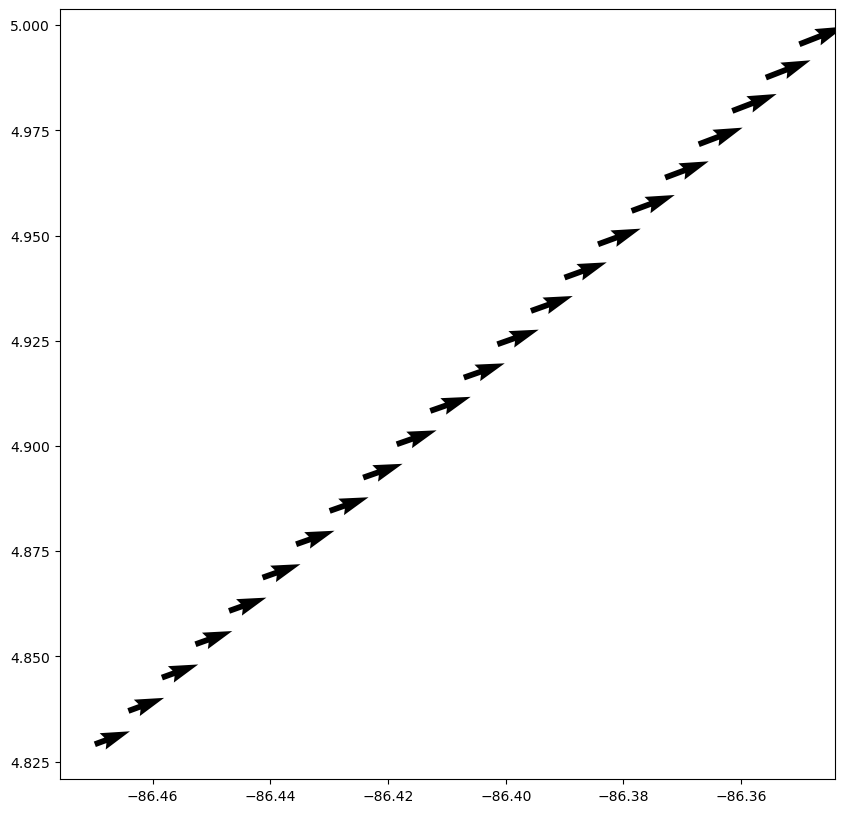

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import math

depth = 7
# Open output and read to x, y, z
ds = xr.open_zarr("./results/sailship_adcp.zarr")
x = ds["lon"][depth]
y = ds["lat"][depth]
U = ds["U"][depth] * 100
V = ds["V"][depth] * 100
x
plt.figure(figsize=(10, 10))
plt.quiver(x, y, U, V)

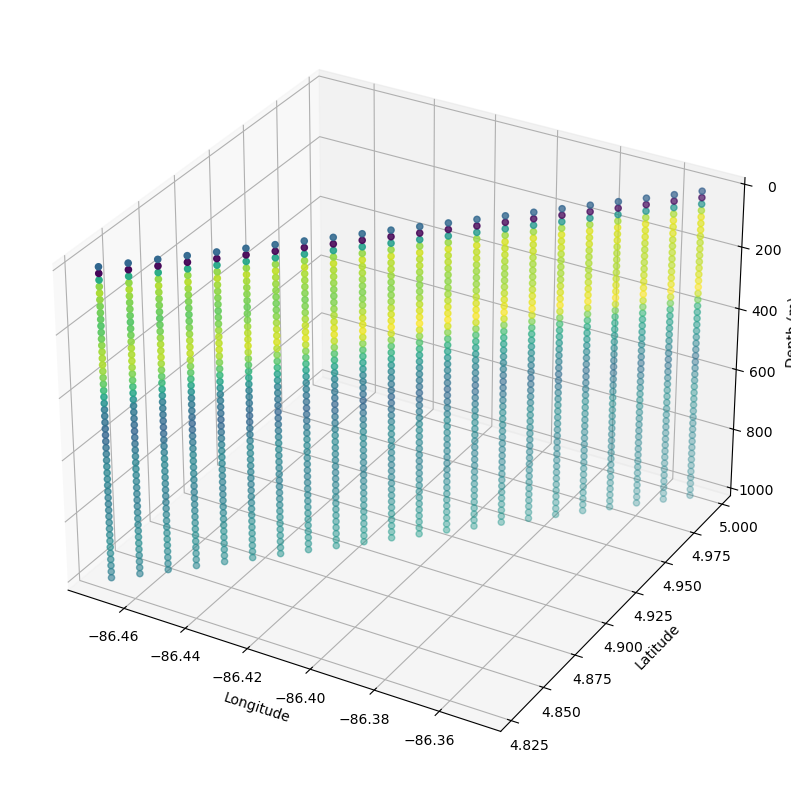

In [3]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# Open output and read to x, y, z
ds = xr.open_zarr("./results/sailship_adcp.zarr")
# ds = xr.open_zarr('tmp.zarr')
x = ds["lon"][:].squeeze()
y = ds["lat"][:].squeeze()
z = ds["z"][:].squeeze()
U = ds["U"][:].squeeze()
V = ds["V"][:].squeeze()
ds.close()

# Plot Particle depth
fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
cb = ax.scatter(x, y, z, c=U, s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z), 0)
plt.show()

In [2]:
import xarray as xr
import numpy as np
from scipy.ndimage import uniform_filter1d

ctd = 2
# rewrite CTD data to cvs
for i in range(0, ctd+2):
    
    # Open output and read to x, y, z
    ds = xr.open_zarr(f"./results/CTD_test_{i+1}.zarr")
    x = ds["lon"][:].squeeze()
    y = ds["lat"][:].squeeze()
    z = ds["z"][:].squeeze()
    time = ds["time"][:].squeeze()
    T = ds["temperature"][:].squeeze()
    S = ds["salinity"][:].squeeze()
    ds.close()

    # add some noise
    random_walk = np.random.random()/10
    z_norm = (z-np.min(z))/(np.max(z)-np.min(z))
    t_norm = np.linspace(0, 1, num=len(time))
    # dS = abs(np.append(0, np.diff(S))) # scale noise with gradient
    # for j in range(5, 0, -1):
    #     dS[dS<1*10**-j] = 0.5-j/10
    # add smoothed random noise scaled with depth (and OPTIONAL with gradient for S) 
    # and random (reversed) diversion from initial through time scaled with depth 
    S = S + uniform_filter1d(
        np.random.random(S.shape)/5*(1-z_norm) + 
        random_walk*(np.max(S).values - np.min(S).values)*(1-z_norm)*t_norm/10, 
        max(int(len(time)/40), 1))
    T = T + uniform_filter1d(
        np.random.random(T.shape)*5*(1-z_norm) - 
        random_walk/2*(np.max(T).values - np.min(T).values)*(1-z_norm)*t_norm/10, 
        max(int(len(time)/20), 1))

    # reshaping data to export to csv
    header = f"'pressure [hPa]','temperature [degC]', 'salinity [g kg-1]'"
    data = np.column_stack([(z/10), T, S])
    new_line = '\n'
    np.savetxt(f"./results/CTD_station_{i+1}.csv", data, fmt="%.4f", header=header, delimiter=',', 
               comments=f'{x.attrs}{new_line}{x[0].values}{new_line}{y.attrs}{new_line}{y[0].values}{new_line}start time: {time[0].values}{new_line}end time: {time[-1].values}{new_line}')


In [8]:
lon = []
lat = []
with open('./results/CTD_station_2.csv', 'r') as file:
    text = file.read().splitlines()
lon.append(text[1])
lat = text[3]
lon, lat

(['-86.87966918945312'], '-0.756813645362854')

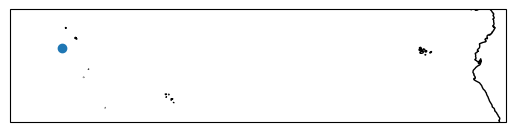

In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-170, -75, 5, -10])
ax.coastlines()

plt.plot(-160, 0, marker='o', transform=ccrs.PlateCarree())

plt.show()

<Axes: >

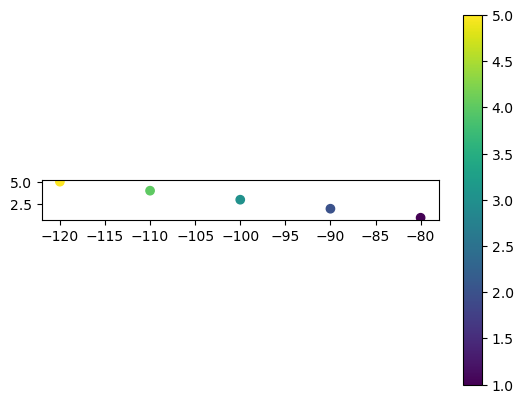

In [14]:
lat = [1, 2, 3, 4, 5]
lon = [-80, -90, -100, -110, -120]
z20 = [1, 2, 3, 4, 5]
import pandas as pd
import geopandas as gpd
df = pd.DataFrame({'lat': lat, 'lon': lon, 'z20': z20})
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(lon, lat))  
gdf.plot(column='z20', legend=True)

ModuleNotFoundError: No module named 'cloupy'

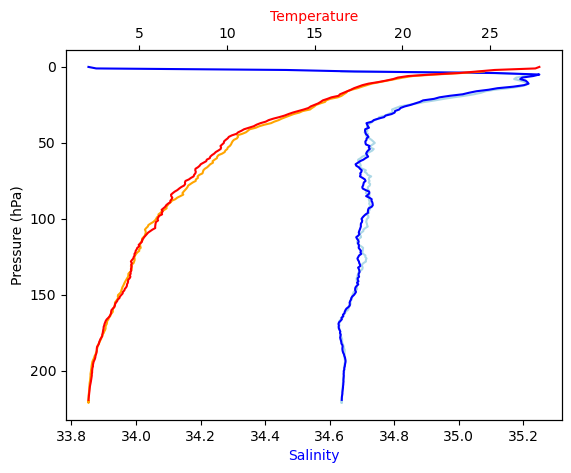

In [1]:
# Read back in... student example
import numpy as np
z, T, S = np.loadtxt('./results/CTD_station_2.csv', delimiter=',', skiprows=5, unpack=True)

# TS plot
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1)
ax1.plot(S[int(len(z)/2):-1], z[int(len(z)/2):-1], color="lightblue")
ax1.plot(S[0:int(len(z)/2)], z[0:int(len(z)/2)], color="b")
ax1.invert_yaxis()
ax1.set_xlabel('Salinity', color = "b")
ax1.set_ylabel('Pressure (hPa)')
ax2 = ax1.twiny() # ax1 and ax2 share y-axis
ax2.set_xlabel('Temperature', color = "r")
ax2.plot(T[int(len(z)/2):-1], z[int(len(z)/2):-1], color="orange")
ax2.plot(T[0:int(len(z)/2)], z[0:int(len(z)/2)], color="r") 
plt.show()

In [ ]:
https://colab.research.google.com/drive/1dabU91WECy5cglb2mVC-8SG4muFNlQrw?usp=sharing